# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
os.chdir('/content/drive/MyDrive/data_twitter')

In [60]:
df_train = pd.read_csv('df_train.csv')
df_val   = pd.read_csv('df_val.csv')
df_test  = pd.read_csv('df_test.csv')

df_train['Sentiment'] = df_train['Sentiment'].astype(int)
df_val['Sentiment']   = df_val['Sentiment'].astype(int)
df_test['Sentiment']  = df_test['Sentiment'].astype(int)

df       = pd.concat([df_train, df_val, df_test], axis=0)
len(df), len(df_train), len(df_val), len(df_test)

(69291, 48503, 10395, 10393)

In [61]:
df = df.drop(columns=[col for col in df.columns if (col != 'Text' and col != 'Sentiment')])

df['Sentiment'] = df['Sentiment'].astype(int)
df.columns = ['text', 'Sentiment']
df.head(2)

,text,Sentiment
0,just finished my second exam only one more to go,0
1,i was so much happier in prison ever since i c...,3


In [62]:
df

,text,Sentiment
0,just finished my second exam only one more to go,0
1,i was so much happier in prison ever since i c...,3
2,can depression be cured by positivity anxiety ...,3
3,rt ur wcw takes depression naps a day worrie...,2
4,reeselasher you guys are hilarious why not jus...,0
...,...,...
10388,libbyextra hey no problem looking forward to ...,0
10389,lilchick is crystal a member of the mile high ...,0
10390,you know there are starving artists in ohio w...,2
10391,subsero ill be calling u oh really take cover,0


In [63]:
 df['Sentiment'].value_counts().sort_index()

0    27202
1     3452
2    28669
3     9968
Name: Sentiment, dtype: int64

In [64]:
pd.unique(df['Sentiment'])

array([0, 3, 2, 1])

In [65]:
sub=df.to_csv("df_merge_dp.csv",index=True)
print(sub)

None


# Nnlm-en-dim50-with-normalization

## Undersampling

In [131]:
MIN = 3452
MAX = 28669

def make_resampled(N=MIN):

  df_resampled = pd.concat([
    df[df['Sentiment'] == 0].sample(N, replace=True),
    df[df['Sentiment'] == 1].sample(N, replace=True),
    df[df['Sentiment'] == 2].sample(N, replace=True),
    df[df['Sentiment'] == 3].sample(N, replace=True)
    ], axis=0)



  return shuffle(df_resampled, random_state=0)

df_shuffled = make_resampled()

In [132]:
df_shuffled.head(5)

,text,Sentiment
3377,anyone else get angry and annoyed by the snall...,3
8909,naive fools living in the sad baby era of oh ...,1
2767,jasminebarton smelly are you okay i love you xxx,0
1668,ninbrevas the depression hours has started,1
2635,rt memetribute me trying to better my mental h...,1


In [133]:
def split_data():
  X = df_shuffled['text'].to_numpy()
  y = df_shuffled['Sentiment'].to_numpy()

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
  X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [134]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data()

In [135]:
np.bincount(y_train)

array([2159, 2175, 2252, 2250])

In [136]:
def  make_dataset():
  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(1000).batch(batch_size=32).cache().prefetch(buffer_size=AUTOTUNE)
  val_ds   = tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(batch_size=32).cache().prefetch(buffer_size=AUTOTUNE)
  test_ds  = tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(1000).batch(batch_size=32).cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, test_ds

In [137]:
train_ds, val_ds, test_ds = make_dataset()

In [138]:
text, sentiment = next(iter(train_ds))
text[:1], sentiment[:1]

(<tf.Tensor: shape=(1,), dtype=string, numpy=
 array([b'craving for kfc mac and cheese and keropok lekor yang lembut semalam nak beli  dua dua tak ada am sad '],
       dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>)

In [139]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(text[:1])

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.5474907 , -0.45049387, -0.18859902, -0.16116884,  0.28194982,
        -0.22120564,  0.00211946,  0.04022539, -0.38360715,  0.03433391,
        -0.00259128, -0.27862245,  0.19475338,  0.12016246,  0.08961579,
         0.16863392,  0.42933056,  0.22435246, -0.0581952 , -0.02788035,
        -0.1733164 , -0.30732197,  0.30595544,  0.12776043, -0.3832446 ,
        -0.3671214 , -0.04830874,  0.05168127, -0.07504752,  0.10559149,
        -0.06721745,  0.51736957, -0.13142896, -0.08514906,  0.0238279 ,
        -0.15684955, -0.01896074,  0.39354372, -0.00520092, -0.24813938,
         0.5951352 ,  0.17395791, -0.20879735, -0.5432923 ,  0.06562831,
         0.320885  , -0.16881767,  0.39211437,  0.04455574,  0.42989486]],
      dtype=float32)>

### Build model

In [140]:
def make_model(embedding = 'https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2'):
  model = tf.keras.Sequential()
  model.add(hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True))
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(4, activation='softmax'))
  return model

model = make_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer  (None, 50)                48190600  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 16)                816       
                                                                 
 dropout_47 (Dropout)        (None, 16)                0         
                                                                 
 dense_15 (Dense)            (None, 4)                 68        
                                                                 
Total params: 48191484 (183.84 MB)
Trainable params: 48191484 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and train

In [141]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


EPOCHS = 30

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

Epoch 1/30
277/277 [==============================] - 70s 248ms/step - loss: 0.9849 - accuracy: 0.5543 - val_loss: 0.6798 - val_accuracy: 0.7412
Epoch 2/30
277/277 [==============================] - 5s 19ms/step - loss: 0.5758 - accuracy: 0.7786 - val_loss: 0.5190 - val_accuracy: 0.7882
Epoch 3/30
277/277 [==============================] - 5s 18ms/step - loss: 0.3937 - accuracy: 0.8605 - val_loss: 0.4796 - val_accuracy: 0.7964
Epoch 4/30
277/277 [==============================] - 5s 17ms/step - loss: 0.2728 - accuracy: 0.9091 - val_loss: 0.4864 - val_accuracy: 0.8045
Epoch 5/30
277/277 [==============================] - 5s 19ms/step - loss: 0.1841 - accuracy: 0.9443 - val_loss: 0.5276 - val_accuracy: 0.7986
Epoch 6/30
277/277 [==============================] - 6s 22ms/step - loss: 0.1328 - accuracy: 0.9610 - val_loss: 0.5807 - val_accuracy: 0.7946
Epoch 7/30
277/277 [==============================] - 5s 18ms/step - loss: 0.0968 - accuracy: 0.9730 - val_loss: 0.6400 - val_accuracy: 0.78

### Evaluation

In [142]:
model.evaluate(test_ds)

87/87 [==============================] - 1s 6ms/step - loss: 0.8035 - accuracy: 0.7839


[0.8034886121749878, 0.7838522791862488]

In [143]:
y_test_pred = model.predict(X_test).argmax(axis=1)

87/87 [==============================] - 0s 4ms/step


In [144]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       722
           1       0.87      0.87      0.87       734
           2       0.63      0.60      0.62       652
           3       0.95      0.98      0.96       654

    accuracy                           0.78      2762
   macro avg       0.78      0.78      0.78      2762
weighted avg       0.78      0.78      0.78      2762



### Predict on new data

In [145]:
t = ['rt psuworldcampus reduce everyday stress and anxiety through these guided meditation videos courtesy of pennstates kami dvorakova',
     'realjameswoods and they care more about other countries citixans then their own sad',
     'lonliness and isolation i literally have no friends even online ones and it makes me feel like such a pathetic piece of shit the only social interactions i have with other human beings is casual meaningless small talk with family and coworkers i dont have anyone that i could truly call a friend i thought i could manage being alone but the isolation has been getting to me as of l']
t_pred = model.predict(t)
np.round(t_pred), t_pred

1/1 [==============================] - 0s 33ms/step


(array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32),
 array([[1.0656586e-04, 9.9974555e-01, 1.4760660e-04, 2.8671252e-07],
        [9.8018354e-01, 1.8429797e-02, 1.1130308e-03, 2.7363276e-04],
        [4.2478439e-07, 1.4784194e-05, 1.8357521e-06, 9.9998295e-01]],
       dtype=float32))

## Oversampling

In [146]:
df_shuffled = make_resampled(N=MAX)
X_train, X_val, X_test, y_train, y_val, y_test = split_data()
train_ds, val_ds, test_ds = make_dataset()

In [147]:
np.bincount(y_train)

array([18357, 18421, 18346, 18268])

### Build model

In [148]:
model = make_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_13 (KerasLayer  (None, 50)                48190600  
 )                                                               
                                                                 
 dense_16 (Dense)            (None, 16)                816       
                                                                 
 dropout_48 (Dropout)        (None, 16)                0         
                                                                 
 dense_17 (Dense)            (None, 4)                 68        
                                                                 
Total params: 48191484 (183.84 MB)
Trainable params: 48191484 (183.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and train

In [149]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/30
2294/2294 [==============================] - 177s 76ms/step - loss: 0.5299 - accuracy: 0.7817 - val_loss: 0.3356 - val_accuracy: 0.8642
Epoch 2/30
2294/2294 [==============================] - 53s 23ms/step - loss: 0.2778 - accuracy: 0.8950 - val_loss: 0.2891 - val_accuracy: 0.8855
Epoch 3/30
2294/2294 [==============================] - 51s 22ms/step - loss: 0.2038 - accuracy: 0.9254 - val_loss: 0.2881 - val_accuracy: 0.8920
Epoch 4/30
2294/2294 [==============================] - 43s 19ms/step - loss: 0.1632 - accuracy: 0.9408 - val_loss: 0.2998 - val_accuracy: 0.8962
Epoch 5/30
2294/2294 [==============================] - 42s 18ms/step - loss: 0.1341 - accuracy: 0.9506 - val_loss: 0.3302 - val_accuracy: 0.9010
Epoch 6/30
2294/2294 [==============================] - 43s 19ms/step - loss: 0.1126 - accuracy: 0.9589 - val_loss: 0.3698 - val_accuracy: 0.9021
Epoch 7/30
2294/2294 [==============================] - 45s 19ms/step - loss: 0.0949 - accuracy: 0.9648 - val_loss: 0.4020 

### Evaluation

In [150]:
model.evaluate(test_ds)

717/717 [==============================] - 3s 5ms/step - loss: 0.8936 - accuracy: 0.9094


[0.8935763835906982, 0.9094436764717102]

In [151]:
y_test_pred = model.predict(X_test).argmax(axis=1)


print(classification_report(y_test, y_test_pred))

717/717 [==============================] - 4s 5ms/step
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      5816
           1       0.96      1.00      0.98      5662
           2       0.84      0.82      0.83      5724
           3       0.98      0.99      0.99      5734

    accuracy                           0.91     22936
   macro avg       0.91      0.91      0.91     22936
weighted avg       0.91      0.91      0.91     22936



(0.0, 2.0)

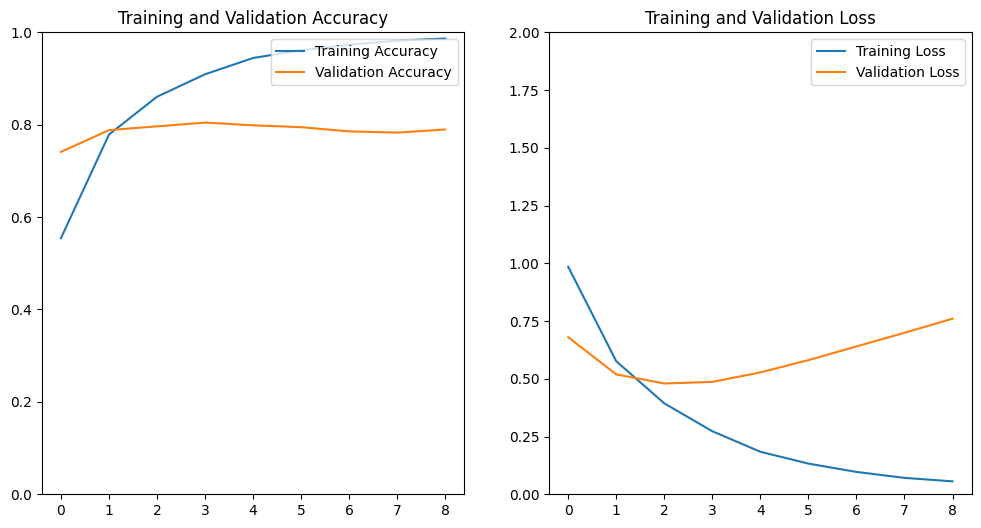

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1.0)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

In [153]:
np.bincount(y_test)

array([5816, 5662, 5724, 5734])

In [154]:
X_test[:6], y_test[:6]

(array(['hiya calling on tv radio papers  please  get behind birmingham mind we need to talk about mental health lets have a phone ins',
        ' hell yeah ',
        'i dont know what to do im feeling so low ive never been like this before but i cant get out of feeling like this i know i should want to go on fir friends and family but the one person who truely made me happy i wronged and they have now left me i built my life around them how do i stop thinking of ending it',
        'rt girlposts when you want to be friends w ppl but ppl think ur mean and unapproachable cus u have a resting bitch face and soci ',
        'concerned my depression is going to get worse i am starting next semester with classes on tuesday and thursday from  and working desk shifts at my university from  i made another bad mistake of doing an internship on mwf from  my oncampus therapistcounseling center hours are only from  and i am really concerned that i will not be able to see my counselor i have gotte

In [155]:
t = ['i have terrible postcon depression help me  ﾟ´д｀ﾟﾟ',
     'decided to quotjoinquot to be a better communicator   well  no where as public as you magoo',
     'on the way to work n just dropped sebby off i miss him ']
y_pred = model.predict(t)

y_pred.argmax(axis=1), np.round(y_pred)

1/1 [==============================] - 0s 38ms/step


(array([1, 0, 2]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=float32))

##Matrice de confusion pour le model nnlm 50

In [161]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
cf_matrix =confusion_matrix(y_test, y_test_pred)
"""
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))
print("F1 Score: {:.2f}%".format(100 * f1_score(y_test, y_pred)))"""

In [162]:
cf_matrix

array([[4826,   91,  867,   32],
       [   2, 5655,    4,    1],
       [ 845,  146, 4677,   56],
       [  10,    4,   19, 5701]])

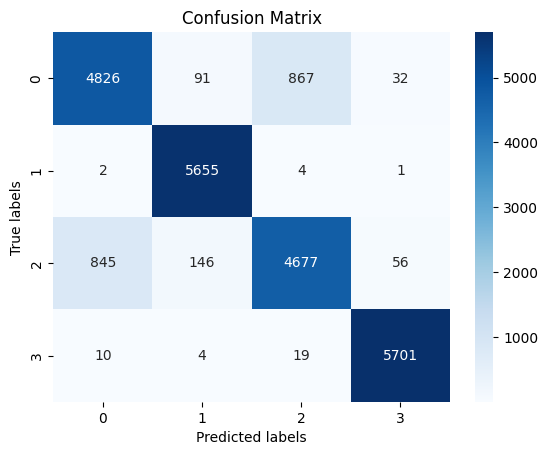

In [164]:
import seaborn as sns
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='');
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

# Nnlm-en-dim128-with-normalization

## Undersampling

In [ ]:
shuffled_df = make_resampled(N=MIN)
X_train, X_val, X_test, y_train, y_val, y_test = split_data()
train_ds, val_ds, test_ds = make_dataset()


In [ ]:
def make_model(embedding = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'):
  model = tf.keras.Sequential()
  model.add(hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True))
  model.add(tf.keras.layers.Dense(16, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(4, activation='softmax'))
  return model

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 124644820 (475.48 MB)
Trainable params: 124644820 (475.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = make_model(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/30
277/277 [==============================] - 64s 207ms/step - loss: 0.9424 - accuracy: 0.5917 - val_loss: 0.6276 - val_accuracy: 0.7688
Epoch 2/30
277/277 [==============================] - 10s 36ms/step - loss: 0.4977 - accuracy: 0.8136 - val_loss: 0.5137 - val_accuracy: 0.7946
Epoch 3/30
277/277 [==============================] - 10s 36ms/step - loss: 0.2945 - accuracy: 0.9023 - val_loss: 0.5352 - val_accuracy: 0.7887
Epoch 4/30
277/277 [==============================] - 10s 36ms/step - loss: 0.1742 - accuracy: 0.9450 - val_loss: 0.5976 - val_accuracy: 0.7792
Epoch 5/30
277/277 [==============================] - 10s 36ms/step - loss: 0.1104 - accuracy: 0.9699 - val_loss: 0.6795 - val_accuracy: 0.7765
Epoch 6/30
277/277 [==============================] - 10s 38ms/step - loss: 0.0808 - accuracy: 0.9767 - val_loss: 0.7346 - val_accuracy: 0.7801
Epoch 7/30
277/277 [==============================] - 11s 40ms/step - loss: 0.0619 - accuracy: 0.9840 - val_loss: 0.8103 - val_accuracy

### Evaluation

In [ ]:
model.evaluate(test_ds)

87/87 [==============================] - 1s 7ms/step - loss: 0.7801 - accuracy: 0.7875


[0.7801399827003479, 0.7874728441238403]

In [ ]:
y_test_pred = model.predict(X_test)

87/87 [==============================] - 1s 8ms/step


In [ ]:
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       722
           1       0.88      0.86      0.87       734
           2       0.63      0.62      0.62       652
           3       0.91      0.97      0.94       654

    accuracy                           0.79      2762
   macro avg       0.78      0.79      0.79      2762
weighted avg       0.79      0.79      0.79      2762



In [ ]:
t = ['I feel very good', 'my head go fine', 'may be need to do some work later']

model.predict(t).argmax(axis=1)

1/1 [==============================] - 0s 60ms/step


array([0, 1, 2])

## Oversampling

In [ ]:
shuffled_df = make_resampled(N=MAX)
X_train, X_val, X_test, y_train, y_val, y_test = split_data()
train_ds, val_ds, test_ds = make_dataset()


In [ ]:
model = make_model(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=[early_stopping])

Epoch 1/5
277/277 [==============================] - 52s 184ms/step - loss: 0.9064 - accuracy: 0.6054 - val_loss: 0.6323 - val_accuracy: 0.7606
Epoch 2/5
277/277 [==============================] - 10s 36ms/step - loss: 0.4846 - accuracy: 0.8265 - val_loss: 0.5250 - val_accuracy: 0.7923
Epoch 3/5
277/277 [==============================] - 10s 36ms/step - loss: 0.2913 - accuracy: 0.9045 - val_loss: 0.5397 - val_accuracy: 0.7873
Epoch 4/5
277/277 [==============================] - 10s 37ms/step - loss: 0.1714 - accuracy: 0.9495 - val_loss: 0.6070 - val_accuracy: 0.7805
Epoch 5/5
277/277 [==============================] - 10s 36ms/step - loss: 0.1115 - accuracy: 0.9710 - val_loss: 0.6793 - val_accuracy: 0.7801


### Evaluation

In [ ]:
model.evaluate(test_ds)

87/87 [==============================] - 1s 7ms/step - loss: 0.6393 - accuracy: 0.7944


[0.6392852067947388, 0.7943519353866577]

In [ ]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

87/87 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       722
           1       0.89      0.87      0.88       734
           2       0.64      0.62      0.63       652
           3       0.92      0.97      0.95       654

    accuracy                           0.79      2762
   macro avg       0.79      0.79      0.79      2762
weighted avg       0.79      0.79      0.79      2762



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1.0)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

# Nnlm-en-dim128-with-normalization with LSTM



In [104]:
import tensorflow as tf
import tensorflow_hub as hub

def make_model(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'):
    model = tf.keras.Sequential()
    model.add(hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True))
    model.add(tf.keras.layers.Reshape((1, 128)))  # Ajoutez cette ligne pour convertir l'entrée en 3D
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    return model

model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape (Reshape)           (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 516       
                                                                 
Total params: 124774788 (475.98 MB)
Trainable params: 124774788 (475.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
model = make_model(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/30
277/277 [==============================] - 61s 199ms/step - loss: 0.7562 - accuracy: 0.6681 - val_loss: 0.5007 - val_accuracy: 0.7982
Epoch 2/30
277/277 [==============================] - 11s 40ms/step - loss: 0.3429 - accuracy: 0.8651 - val_loss: 0.4832 - val_accuracy: 0.8009
Epoch 3/30
277/277 [==============================] - 11s 39ms/step - loss: 0.1721 - accuracy: 0.9415 - val_loss: 0.5600 - val_accuracy: 0.8005
Epoch 4/30
277/277 [==============================] - 11s 41ms/step - loss: 0.0869 - accuracy: 0.9690 - val_loss: 0.6857 - val_accuracy: 0.7873
Epoch 5/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0512 - accuracy: 0.9834 - val_loss: 0.7842 - val_accuracy: 0.7919
Epoch 6/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0319 - accuracy: 0.9911 - val_loss: 0.8922 - val_accuracy: 0.7851
Epoch 7/30
277/277 [==============================] - 10s 38ms/step - loss: 0.0219 - accuracy: 0.9940 - val_loss: 0.9642 - val_accuracy

### Evaluation

In [106]:
model.evaluate(test_ds)

87/87 [==============================] - 1s 9ms/step - loss: 1.0073 - accuracy: 0.7965


[1.007290244102478, 0.7965242862701416]

In [107]:
y_test_pred = model.predict(X_test)

87/87 [==============================] - 1s 7ms/step


In [108]:
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.69      0.74      0.72       722
           1       0.86      0.87      0.87       734
           2       0.67      0.60      0.63       652
           3       0.96      0.97      0.96       654

    accuracy                           0.80      2762
   macro avg       0.79      0.80      0.79      2762
weighted avg       0.79      0.80      0.79      2762



In [109]:
t = ['I feel very good', 'my head go fine', 'may be need to do some work later']

model.predict(t).argmax(axis=1)

1/1 [==============================] - 0s 57ms/step


array([0, 0, 0])

## Oversampling

In [118]:
shuffled_df = make_resampled(N=MAX)
X_train, X_val, X_test, y_train, y_val, y_test = split_data()
train_ds, val_ds, test_ds = make_dataset()

np.bincount(y_train)

array([2159, 2175, 2252, 2250])

In [119]:
model = make_model(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

Epoch 1/30
277/277 [==============================] - 52s 178ms/step - loss: 0.7627 - accuracy: 0.6692 - val_loss: 0.5046 - val_accuracy: 0.7914
Epoch 2/30
277/277 [==============================] - 11s 40ms/step - loss: 0.3486 - accuracy: 0.8658 - val_loss: 0.4746 - val_accuracy: 0.8090
Epoch 3/30
277/277 [==============================] - 11s 39ms/step - loss: 0.1733 - accuracy: 0.9397 - val_loss: 0.5601 - val_accuracy: 0.8014
Epoch 4/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0834 - accuracy: 0.9739 - val_loss: 0.6842 - val_accuracy: 0.7928
Epoch 5/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0474 - accuracy: 0.9852 - val_loss: 0.8071 - val_accuracy: 0.7928
Epoch 6/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0318 - accuracy: 0.9905 - val_loss: 0.9081 - val_accuracy: 0.7914
Epoch 7/30
277/277 [==============================] - 11s 39ms/step - loss: 0.0206 - accuracy: 0.9940 - val_loss: 1.0143 - val_accuracy

### Evaluation



In [120]:
model.evaluate(test_ds)

87/87 [==============================] - 1s 8ms/step - loss: 1.0539 - accuracy: 0.7929


[1.0539401769638062, 0.79290372133255]

In [121]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

87/87 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       722
           1       0.84      0.88      0.86       734
           2       0.68      0.56      0.61       652
           3       0.96      0.97      0.96       654

    accuracy                           0.79      2762
   macro avg       0.79      0.79      0.79      2762
weighted avg       0.79      0.79      0.79      2762



##GridSeach CV

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import  KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping

def mmodel(embedding='https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'):
    model = tf.keras.Sequential()
    model.add(hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True))
    model.add(tf.keras.layers.Reshape((1, 128)))  # Ajoutez cette ligne pour convertir l'entrée en 3D
    model.add(tf.keras.layers.LSTM(128))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Supposons que X_train est une série ou un tableau 1D
X_train = np.array(X_train)  # Convertissez X_train en tableau numpy
X_train = X_train.reshape(-1, 1)  # Remodelez X_train en 2D

param={"epochs":[16,30,50,100,500], "batch_size":[32,40,60,100]}
model_gd=KerasClassifier(model=mmodel)
model_gd.set_params(fit__batch_size=32, predict__batch_size=10000)
model_gd.fit(X=train_ds, y=y_train, epochs=30, callbacks=[early_stopping])
grid_search=GridSearchCV(estimator=model_gd,param_grid=param,scoring='accuracy',cv=10)


In [ ]:
grid_search

GridSearchCV(cv=10,
             estimator=KerasClassifier(fit__batch_size=32, model=<function mmodel at 0x7b39f8e07c70>, predict__batch_size=10000),
             param_grid={'batch_size': [32, 40, 60, 100],
                         'epochs': [16, 30, 50, 100, 500]},
             scoring='accuracy')

In [ ]:
best_param=grid_search.get_params
best_param

<bound method BaseEstimator.get_params of GridSearchCV(cv=10,
             estimator=KerasClassifier(build_fn=<function mmodel at 0x7b39f9352f80>),
             param_grid={'batch_size': [32, 40, 60, 100],
                         'epochs': [16, 30, 50, 100, 500]},
             scoring='accuracy')>

## small BERT

In [20]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 9.5 MB/s eta 0:00:00


In [21]:
import tensorflow_text as text

In [165]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [123]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['using tweets for sentiment detection!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  2478  1056 28394  3215  2005 15792 10788   999   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [24]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)


bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9902758   0.9488596  -0.57447565  0.2359788   0.21087882  0.72540236
  0.99133396 -0.9693253  -0.45574492 -0.99491817 -0.38793358 -0.8961423 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.738555    0.38460904  0.62248194 ...  0.20718446  0.9878832
   0.17118537]
 [-1.0783944   0.6805973   0.9143313  ...  0.22467422  0.06419053
   0.8062776 ]
 [-0.42755163  0.36517045  0.27413124 ...  0.55077744  0.25483873
  -0.3847758 ]
 ...
 [-0.81761974  0.02183659  1.3033448  ...  0.16059618  0.75462055
  -0.01782459]
 [-0.48506057  0.3536407   0.36651036 ...  0.603565    0.87447816
   0.14828727]
 [-0.5780486   0.50469846  0.43850553 ...  0.47662982  0.5860176
   0.21449932]]


In [166]:
def build_classifier_model(num_classes=16):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net1 = tf.keras.layers.Dropout(0.1)(net)
    net2 = tf.keras.layers.Dense(num_classes, activation='relu')(net1)
    net3 = tf.keras.layers.Dropout(0.2)(net2)
    net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net3)
    return tf.keras.Model(text_input, net)

In [167]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                              

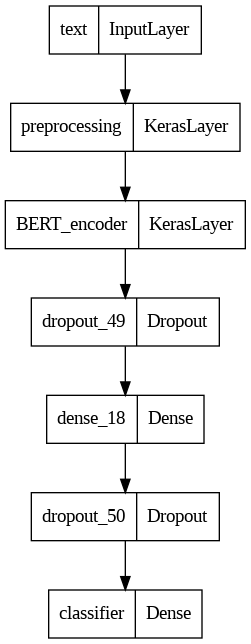

In [168]:
tf.keras.utils.plot_model(classifier_model)

In [127]:
pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.8 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=8d7a4088066343ad5e3d56eb5e01e0d5b18d6f4faf1e7870099070160d7c6bd6
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [169]:
df_shuffled = make_resampled(N=MAX)
X_train, X_val, X_test, y_train, y_val, y_test = split_data()
train_ds, val_ds, test_ds = make_dataset()

np.bincount(y_train)

array([18357, 18421, 18346, 18268])

In [170]:
from official.nlp import optimization
epochs = 30
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])



early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy')
history = classifier_model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[early_stopping])

Epoch 1/30
2294/2294 [==============================] - 651s 280ms/step - loss: 0.7985 - accuracy: 0.6522 - val_loss: 0.4649 - val_accuracy: 0.8120
Epoch 2/30
2294/2294 [==============================] - 619s 270ms/step - loss: 0.4553 - accuracy: 0.8192 - val_loss: 0.3593 - val_accuracy: 0.8598
Epoch 3/30
2294/2294 [==============================] - 621s 271ms/step - loss: 0.3493 - accuracy: 0.8662 - val_loss: 0.2978 - val_accuracy: 0.8872
Epoch 4/30
2294/2294 [==============================] - 620s 270ms/step - loss: 0.2568 - accuracy: 0.9064 - val_loss: 0.2792 - val_accuracy: 0.9066
Epoch 5/30
2294/2294 [==============================] - 639s 279ms/step - loss: 0.1933 - accuracy: 0.9340 - val_loss: 0.2976 - val_accuracy: 0.9120
Epoch 6/30
2294/2294 [==============================] - 618s 269ms/step - loss: 0.1494 - accuracy: 0.9545 - val_loss: 0.3206 - val_accuracy: 0.9239
Epoch 7/30
2294/2294 [==============================] - 635s 277ms/step - loss: 0.1246 - accuracy: 0.9645 - val_

(0.0, 2.0)

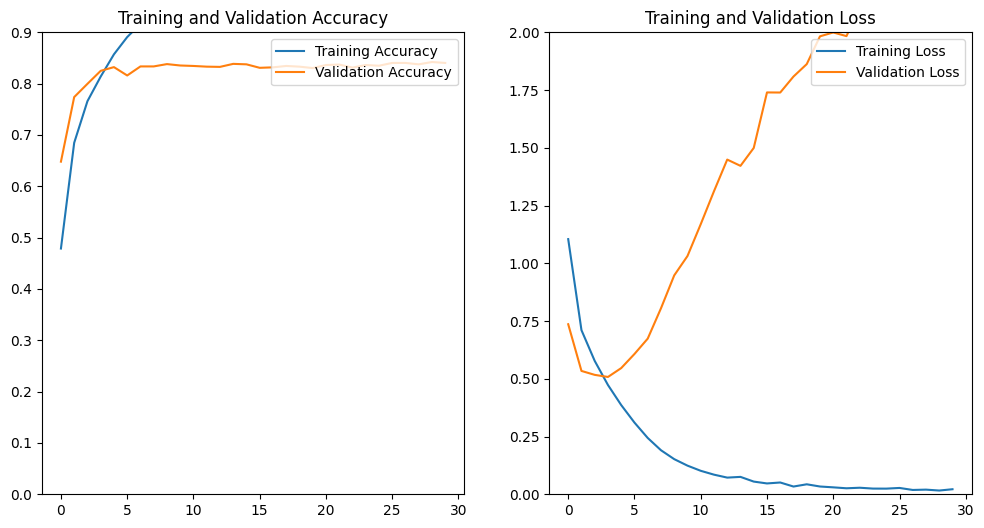

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,1.0)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

In [ ]:
classifier_model.evaluate(test_ds)

87/87 [==============================] - 16s 185ms/step - loss: 2.0757 - accuracy: 0.8450


[2.075659990310669, 0.8450398445129395]

In [ ]:
y_test_pred = classifier_model.predict(X_test)
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

87/87 [==============================] - 13s 147ms/step
              precision    recall  f1-score   support

           0       0.76      0.77      0.76       722
           1       0.89      0.94      0.91       734
           2       0.73      0.68      0.70       652
           3       1.00      0.99      0.99       654

    accuracy                           0.85      2762
   macro avg       0.84      0.84      0.84      2762
weighted avg       0.84      0.85      0.84      2762



##Matrice de confusion pour le model BERT

## BERT FINE TUNINE

In [23]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00


In [25]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

In [26]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [76]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [77]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [78]:
X_train

array(['thinks chelseajadexo is going to be missed beyong belief ',
       'can a victim of sex trafficking ever fully recover  i fear everything my boyfriend gets upset when he cant touch me at all due to ptsd every noise makes me tremble and i always think that something bad will happen i feel like ive been through so much i can just turn my numb button on how i am now affects all my relationships with people even if im sitting in a car too long i get so scared someone will hurt me or do something that i always have to be aware of my surroundings if you might get triggered by sexual abuse i strongly suggest to not read the rest not going to go into a lot of details but about a year ago i was sex trafficked i always seen girls on the tv and thought it was  in a million and could never happen to me until it did and when it did i became aware of how big it actually is and how often it happens after i had managed to escape last may i was in impatient hospital care for  months to help wit

In [87]:
#data_encoded = train_ds.map(tokenize, batched=True, batch_size=None)

data_x_encoded = tokenizer(list(X_train), padding=True, truncation=True, return_tensors="pt")

In [88]:
data_x_encoded

{'input_ids': tensor([[  101,  6732,  9295,  ...,     0,     0,     0],
        [  101,  2064,  1037,  ...,     0,     0,     0],
        [  101, 19387,  3730,  ...,     0,     0,     0],
        ...,
        [  101,  9508,  9516,  ...,     0,     0,     0],
        [  101,  7514, 20389,  ...,     0,     0,     0],
        [  101, 28616,  2480,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [89]:
y_train

array([2, 3, 1, ..., 2, 0, 0])

In [90]:
import tensorflow as tf

# Assuming you have a Hugging Face dataset 'data_encoded' with columns: input_ids, attention_mask, token_type_ids, and label

# Convert your 'data_encoded' dataset to TensorFlow tensors
tf_input_ids = tf.constant(data_encoded['input_ids'])
tf_attention_mask = tf.constant(data_encoded['attention_mask'])
tf_token_type_ids = tf.constant(data_encoded['token_type_ids'])
tf_labels = tf.constant(y_train)

# Now you have the data as TensorFlow tensors that you can use for further processing.


In [91]:
data_xt_encoded = tokenizer(list(X_test), padding=True, truncation=True, return_tensors="pt")

In [93]:
# setting BATCH_SIZE to 64.
BATCH_SIZE = 64

def order(inp):
    '''
    This function will group all the inputs of BERT
    into a single dictionary and then output it with
    labels.
    '''
    return {
        'input_ids': tf_input_ids,
        'attention_mask': tf_attention_mask,
        'token_type_ids': tf_token_type_ids
    }, tf_labels

# converting train split of `emotions_encoded` to tensorflow format
train_dataset = tf.data.Dataset.from_tensor_slices(data_x_encoded)
# set batch_size and shuffle
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000)
# map the `order` function
train_dataset = train_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

# ... doing the same for test set ...
test_dataset = tf.data.Dataset.from_tensor_slices(data_xt_encoded)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.map(order, num_parallel_calls=tf.data.AUTOTUNE)

In [94]:
inp, out = next(iter(train_dataset)) # a batch from train_dataset
print(inp, '\n\n', out)

{'input_ids': <tf.Tensor: shape=(8836, 512), dtype=int64, numpy=
array([[  101,  6732,  9295, ...,     0,     0,     0],
       [  101,  2064,  1037, ...,     0,     0,     0],
       [  101, 19387,  3730, ...,     0,     0,     0],
       ...,
       [  101,  9508,  9516, ...,     0,     0,     0],
       [  101,  7514, 20389, ...,     0,     0,     0],
       [  101, 28616,  2480, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(8836, 512), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'token_type_ids': <tf.Tensor: shape=(8836, 512), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>} 

 tf.Tensor([2 3 1 ... 2 0 0], 

In [101]:
class BERTForClassification(tf.keras.Model):

    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.bert(inputs)[1]
        return self.fc(x)

In [102]:
classifier = BERTForClassification(model, num_classes=4)

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [103]:
history = classifier.fit(
  train_dataset,
    epochs=30
)

Epoch 1/30


ValueError: ignored

In [ ]:
classifier.evaluate(test_dataset)

# **BERT**

In [ ]:
import sys

assert sys.version_info >= (3, 7)

In [ ]:
if "google.colab" in sys.modules:
    %pip install -q -U transformers
    %pip install -q -U datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # many other tasks are available
result = classifier("detection depression tweets.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [ ]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

[{'label': 'contradiction', 'score': 0.9790191650390625}]

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [ ]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [ ]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123812 ,  1.1786786 ,  1.4101006 ],
       [-0.01478313,  1.0962478 , -0.9919961 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [ ]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619703, 0.43523577, 0.54856724],
       [0.22655976, 0.6881726 , 0.0852677 ]], dtype=float32)>

In [ ]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [ ]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 50s 50s/step - loss: 0.8016 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 67ms/step - loss: 0.1767 - accuracy: 1.0000


In [ ]:
from transformers import TFBertForMaskedLM

# Charger un modèle BERT pré-entraîné, par exemple "bert-base-uncased"
model = TFBertForMaskedLM.from_pretrained("bert-base-uncased")


All PyTorch model weights were used when initializing TFBertForMaskedLM.

All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
from transformers import BertTokenizer

# Charger un tokenizer BERT pré-entraîné, par exemple "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
!pip install nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.3 MB/s eta 0:00:00
